In [17]:
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN

pd.set_option('display.max_columns', 500)


In [2]:
dataset= pickle.load(open('ts_with_weather.p', 'rb'))

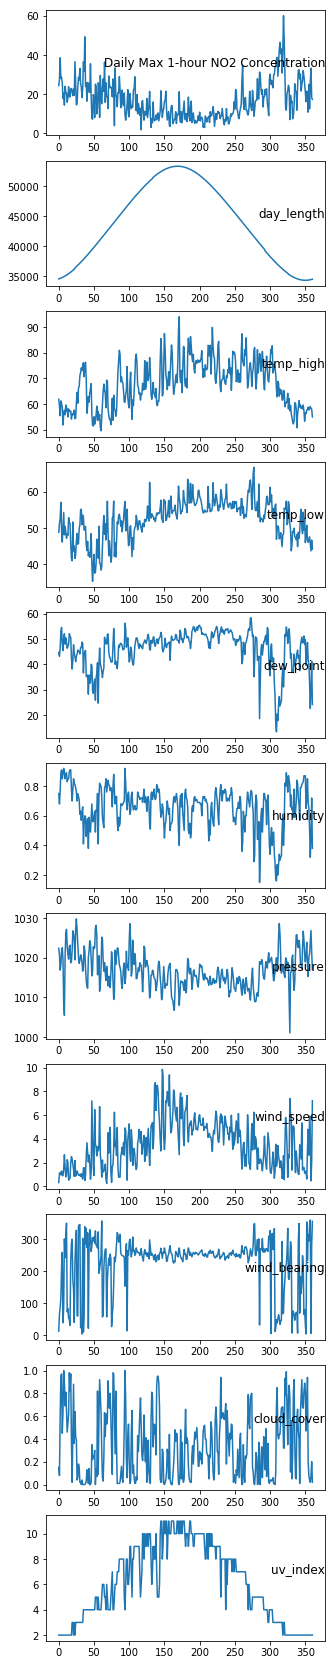

In [3]:
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3,4, 5, 6, 7, 8, 9, 10]
i = 1

# plot each column
plt.figure(figsize=(5,30))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [4]:
train = dataset.query('Date < "2018-07-01"')
valid = dataset.query('Date >= "2018-07-01" and Date < "2018-11-01"')
test = dataset.query('Date >= "2018-11-02"')

In [5]:
train

,Daily Max 1-hour NO2 Concentration,day_length,temp_high,temp_low,dew_point,humidity,pressure,wind_speed,wind_bearing,cloud_cover,uv_index
Date,,,,,,,,,,,
2018-01-01,24.3,34521,61.80,48.78,44.72,0.75,1022.35,0.31,13,0.15,2
2018-01-02,27.3,34562,59.30,51.17,43.18,0.68,1020.78,1.09,67,0.08,2
2018-01-03,38.5,34608,55.40,52.62,46.33,0.77,1016.84,1.15,86,0.59,2
2018-01-04,28.0,34657,61.19,57.04,53.00,0.89,1018.21,0.97,115,0.95,2
2018-01-05,28.5,34708,60.22,49.27,54.58,0.91,1021.69,1.28,211,0.97,2
2018-01-06,25.6,34763,58.72,46.09,48.08,0.85,1022.49,0.90,258,0.45,2
2018-01-07,17.7,34821,51.83,50.17,45.45,0.88,1019.53,0.89,39,0.64,2
2018-01-08,20.4,34883,55.71,54.27,50.27,0.92,1008.78,1.44,88,1.00,2
2018-01-09,14.3,34947,57.55,48.07,52.07,0.90,1005.43,2.65,300,0.90,2


In [6]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 


In [43]:
# load dataset
values = dataset.values
# integer encode direction
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, 2)
# drop columns we don't want to predict

reframed.head()

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),var11(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var8(t-6),var9(t-6),var10(t-6),var11(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),var11(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var9(t-4),var10(t-4),var11(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),var11(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var5(t+1),var6(t+1),var7(t+1),var8(t+1),var9(t+1),var10(t+1),var11(t+1)
7,0.387650,0.011802,0.275885,0.429799,0.697064,0.779221,0.742184,0.008316,0.025352,0.15,0.0,0.439108,0.013962,0.219490,0.505890,0.662811,0.688312,0.687634,0.089397,0.177465,0.08,0.0,0.631218,0.016386,0.131514,0.552053,0.732874,0.805195,0.550732,0.095634,0.230986,0.59,0.0,0.451115,0.018967,0.262125,0.692773,0.881228,0.961039,0.598335,0.076923,0.312676,0.95,0.0,0.459691,0.021654,0.240244,0.445400,0.916370,0.987013,0.719250,0.109148,0.583099,0.97,0.0,0.409949,0.024552,0.206406,0.344158,0.771797,0.909091,0.747047,0.069647,0.715493,0.45,0.0,0.274443,0.027608,0.050981,0.474053,0.713301,0.948052,0.644199,0.068607,0.098592,0.64,0.0,0.320755,0.030874,0.138507,0.604584,0.820507,1.000000,0.270676,0.125780,0.236620,1.00,0.0,0.216124,0.034247,0.180013,0.407195,0.860543,0.974026,0.154274,0.251559,0.833803,0.90,0.0
8,0.439108,0.013962,0.219490,0.505890,0.662811,0.688312,0.687634,0.089397,0.177465,0.08,0.0,0.631218,0.016386,0.131514,0.552053,0.732874,0.805195,0.550732,0.095634,0.230986,0.59,0.0,0.451115,0.018967,0.262125,0.692773,0.881228,0.961039,0.598335,0.076923,0.312676,0.95,0.0,0.459691,0.021654,0.240244,0.445400,0.916370,0.987013,0.719250,0.109148,0.583099,0.97,0.0,0.409949,0.024552,0.206406,0.344158,0.771797,0.909091,0.747047,0.069647,0.715493,0.45,0.0,0.274443,0.027608,0.050981,0.474053,0.713301,0.948052,0.644199,0.068607,0.098592,0.64,0.0,0.320755,0.030874,0.138507,0.604584,0.820507,1.000000,0.270676,0.125780,0.236620,1.00,0.0,0.216124,0.034247,0.180013,0.407195,0.860543,0.974026,0.154274,0.251559,0.833803,0.90,0.0,0.380789,0.037777,0.140988,0.482012,0.769128,0.909091,0.663658,0.142412,0.667606,0.69,0.0
9,0.631218,0.016386,0.131514,0.552053,0.732874,0.805195,0.550732,0.095634,0.230986,0.59,0.0,0.451115,0.018967,0.262125,0.692773,0.881228,0.961039,0.598335,0.076923,0.312676,0.95,0.0,0.459691,0.021654,0.240244,0.445400,0.916370,0.987013,0.719250,0.109148,0.583099,0.97,0.0,0.409949,0.024552,0.206406,0.344158,0.771797,0.909091,0.747047,0.069647,0.715493,0.45,0.0,0.274443,0.027608,0.050981,0.474053,0.713301,0.948052,0.644199,0.068607,0.098592,0.64,0.0,0.320755,0.030874,0.138507,0.604584,0.820507,1.000000,0.270676,0.125780,0.236620,1.00,0.0,0.216124,0.034247,0.180013,0.407195,0.860543,0.974026,0.154274,0.251559,0.833803,0.90,0.0,0.380789,0.037777,0.140988,0.482012,0.769128,0.909091,0.663658,0.142412,0.667606,0.69,0.0,0.327616,0.041517,0.226934,0.435530,0.824288,0.948052,0.873177,0.058212,0.861972,0.81,0.0
10,0.451115,0.018967,0.262125,0.692773,0.881228,0.961039,0.598335,0.076923,0.312676,0.95,0.0,0.459691,0.021654,0.240244,0.445400,0.916370,0.987013,0.719250,0.109148,0.583099,0.97,0.0,0.409949,0.024552,0.206406,0.344158,0.771797,0.909091,0.747047,0.069647,0.715493,0.45,0.0,0.274443,0.027608,0.050981,0.474053,0.713301,0.948052,0.644199,0.068607,0.098592,0.64,0.0,0.320755,0.030874,0.138507,0.604584,0.820507,1.000000,0.270676,0.125780,0.236620,1.00,0.0,0.216124,0.034247,0.180013,0.407195,0.860543,0.974026,0.154274,0.251559,0.833803,0.90,0.0,0.380789,0.037777,0.140988,0.48201

In [44]:

# split into train and test sets
values = reframed.values
n_train_days = 300
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(300, 1, 98) (300,) (53, 1, 98) (53,)


Train on 300 samples, validate on 53 samples
Epoch 1/100
 - 2s - loss: 0.7218 - val_loss: 0.0866
Epoch 2/100
 - 0s - loss: 0.5534 - val_loss: 0.1576
Epoch 3/100
 - 0s - loss: 0.4215 - val_loss: 0.2545
Epoch 4/100
 - 0s - loss: 0.3304 - val_loss: 0.3342
Epoch 5/100
 - 0s - loss: 0.2868 - val_loss: 0.3768
Epoch 6/100
 - 0s - loss: 0.2658 - val_loss: 0.3935
Epoch 7/100
 - 0s - loss: 0.2503 - val_loss: 0.3936
Epoch 8/100
 - 0s - loss: 0.2369 - val_loss: 0.3816
Epoch 9/100
 - 0s - loss: 0.2245 - val_loss: 0.3604
Epoch 10/100
 - 0s - loss: 0.2126 - val_loss: 0.3326
Epoch 11/100
 - 0s - loss: 0.2005 - val_loss: 0.3019
Epoch 12/100
 - 0s - loss: 0.1884 - val_loss: 0.2720
Epoch 13/100
 - 0s - loss: 0.1768 - val_loss: 0.2437
Epoch 14/100
 - 0s - loss: 0.1655 - val_loss: 0.2183
Epoch 15/100
 - 0s - loss: 0.1549 - val_loss: 0.1970
Epoch 16/100
 - 0s - loss: 0.1427 - val_loss: 0.1861
Epoch 17/100
 - 0s - loss: 0.1289 - val_loss: 0.1818
Epoch 18/100
 - 0s - loss: 0.1186 - val_loss: 0.1741
Epoch 19/1

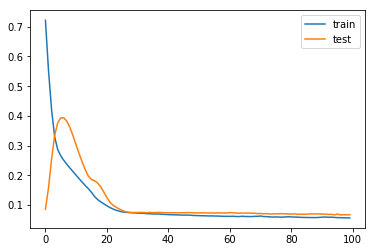

In [45]:

# design network
model = Sequential()
model.add(LSTM(7, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Train on 300 samples, validate on 53 samples
Epoch 1/100
 - 2s - loss: 0.4252 - val_loss: 0.7378
Epoch 2/100
 - 0s - loss: 0.3737 - val_loss: 0.6860
Epoch 3/100
 - 0s - loss: 0.3457 - val_loss: 0.6219
Epoch 4/100
 - 0s - loss: 0.3200 - val_loss: 0.5498
Epoch 5/100
 - 0s - loss: 0.2965 - val_loss: 0.4786
Epoch 6/100
 - 0s - loss: 0.2722 - val_loss: 0.4196
Epoch 7/100
 - 0s - loss: 0.2468 - val_loss: 0.3733
Epoch 8/100
 - 0s - loss: 0.2210 - val_loss: 0.3343
Epoch 9/100
 - 0s - loss: 0.1999 - val_loss: 0.2878
Epoch 10/100
 - 0s - loss: 0.1843 - val_loss: 0.2375
Epoch 11/100
 - 0s - loss: 0.1738 - val_loss: 0.2045
Epoch 12/100
 - 0s - loss: 0.1634 - val_loss: 0.1886
Epoch 13/100
 - 0s - loss: 0.1559 - val_loss: 0.1794
Epoch 14/100
 - 0s - loss: 0.1510 - val_loss: 0.1707
Epoch 15/100
 - 0s - loss: 0.1475 - val_loss: 0.1645
Epoch 16/100
 - 0s - loss: 0.1456 - val_loss: 0.1619
Epoch 17/100
 - 0s - loss: 0.1439 - val_loss: 0.1599
Epoch 18/100
 - 0s - loss: 0.1412 - val_loss: 0.1579
Epoch 19/1

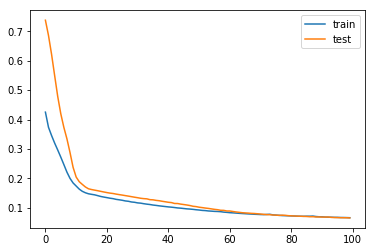

In [46]:
simple_rnn = Sequential()
simple_rnn.add(SimpleRNN(7, input_shape=(train_X.shape[1], train_X.shape[2])))
simple_rnn.add(Dense(1))
simple_rnn.compile(loss='mae', optimizer='adam')
               
history = simple_rnn.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Train on 300 samples, validate on 53 samples
Epoch 1/100
 - 3s - loss: 0.2659 - val_loss: 0.4722
Epoch 2/100
 - 0s - loss: 0.2104 - val_loss: 0.3058
Epoch 3/100
 - 0s - loss: 0.1945 - val_loss: 0.1343
Epoch 4/100
 - 0s - loss: 0.1746 - val_loss: 0.0844
Epoch 5/100
 - 0s - loss: 0.1337 - val_loss: 0.0677
Epoch 6/100
 - 0s - loss: 0.1041 - val_loss: 0.0553
Epoch 7/100
 - 0s - loss: 0.1171 - val_loss: 0.0722
Epoch 8/100
 - 0s - loss: 0.1211 - val_loss: 0.0491
Epoch 9/100
 - 0s - loss: 0.1094 - val_loss: 0.0450
Epoch 10/100
 - 0s - loss: 0.0988 - val_loss: 0.0464
Epoch 11/100
 - 0s - loss: 0.1010 - val_loss: 0.0521
Epoch 12/100
 - 0s - loss: 0.0885 - val_loss: 0.0494
Epoch 13/100
 - 0s - loss: 0.0990 - val_loss: 0.0500
Epoch 14/100
 - 0s - loss: 0.0889 - val_loss: 0.0522
Epoch 15/100
 - 0s - loss: 0.0936 - val_loss: 0.0532
Epoch 16/100
 - 0s - loss: 0.1002 - val_loss: 0.0513
Epoch 17/100
 - 0s - loss: 0.0873 - val_loss: 0.0540
Epoch 18/100
 - 0s - loss: 0.0859 - val_loss: 0.0569
Epoch 19/1

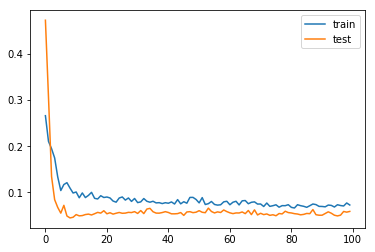

In [47]:
##GRU

# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]), dropout = .2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()